In [1]:
import os
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import numpy as np
import matplotlib.pyplot as plt
import sage 

/home/jlm217/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/stopah/data') 

pd.set_option('display.max_columns', None)  

ro.r['load']('STOPAH_ForSolon.RData')

def R_dataset(x):
    with (ro.default_converter + pandas2ri.converter).context():
        stopah = ro.conversion.get_conversion().rpy2py(ro.r[x])
    return stopah

stopah = R_dataset('stopah')

R[write to console]: Warning:
R[write to console]:  namespace ‘pROC’ is not available and has been replaced
by .GlobalEnv when processing object ‘roc.objs’



In [3]:
selected = ['D28_DTH','D90_DTH','Prednisolone']

baseline = ['Gender','Baseline_sepsis','Baseline_GIB',
'Age.at.randomisation..calc.','Weight','Max.grams.of.alcohol.drunk.per.day..calc.','Hepatic.Encephalopathy...Merged',
'Temperature...Merged','Pulse...Merged','Systolic.BP...Merged','Diastolic.BP...Merged','MAP','Hb...Merged','Platelets...Merged',
'WBC...Merged','Neutrophils...Merged','INR...Merged.clinical.and.calc','Bilirubin.Merged','ALT...Merged','ALP...Merged',
'Albumin...Merged','Sodium...Merged','Potassium...Merged','Urea...Merged','Creatinine...Merged','NLR_0','bDNA',
'Ferritin_ngml','Iron_mumoll','Transferrin','TSAT','PNPLA3_Add','PNPLA3_Rec','HPCT_NG'] 

sevenday = ['Hepatic.Encephalopathy...Treatment.Day.7..',
'Day.7.infection',
'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
'Temperature..Treatment.Day.7..',
'Pulse..Treatment.Day.7..',
'Systolic.BP..Treatment.Day.7..',
'Diastolic.BP..Treatment.Day.7..',
'MAP..Treatment.Day.7',
'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
'Platelets.day.7',
'WBC.day.7',
'Neutrophils.day.7',
'INR.clinical.and.calc.day.7',
'Bilirubin.day.7',
'ALT.day.7',
'ALP.day.7',
'Albumin.day.7',
'Sodium.day.7',
'Potassium.day.7',
'Urea.day.7',
'Creatinine.day.7']

#reduce data set to target, treatment and therapy

stopah = stopah[sevenday+['Prednisolone','D28_DTH']]

stopah.reset_index(drop=True, inplace=True)

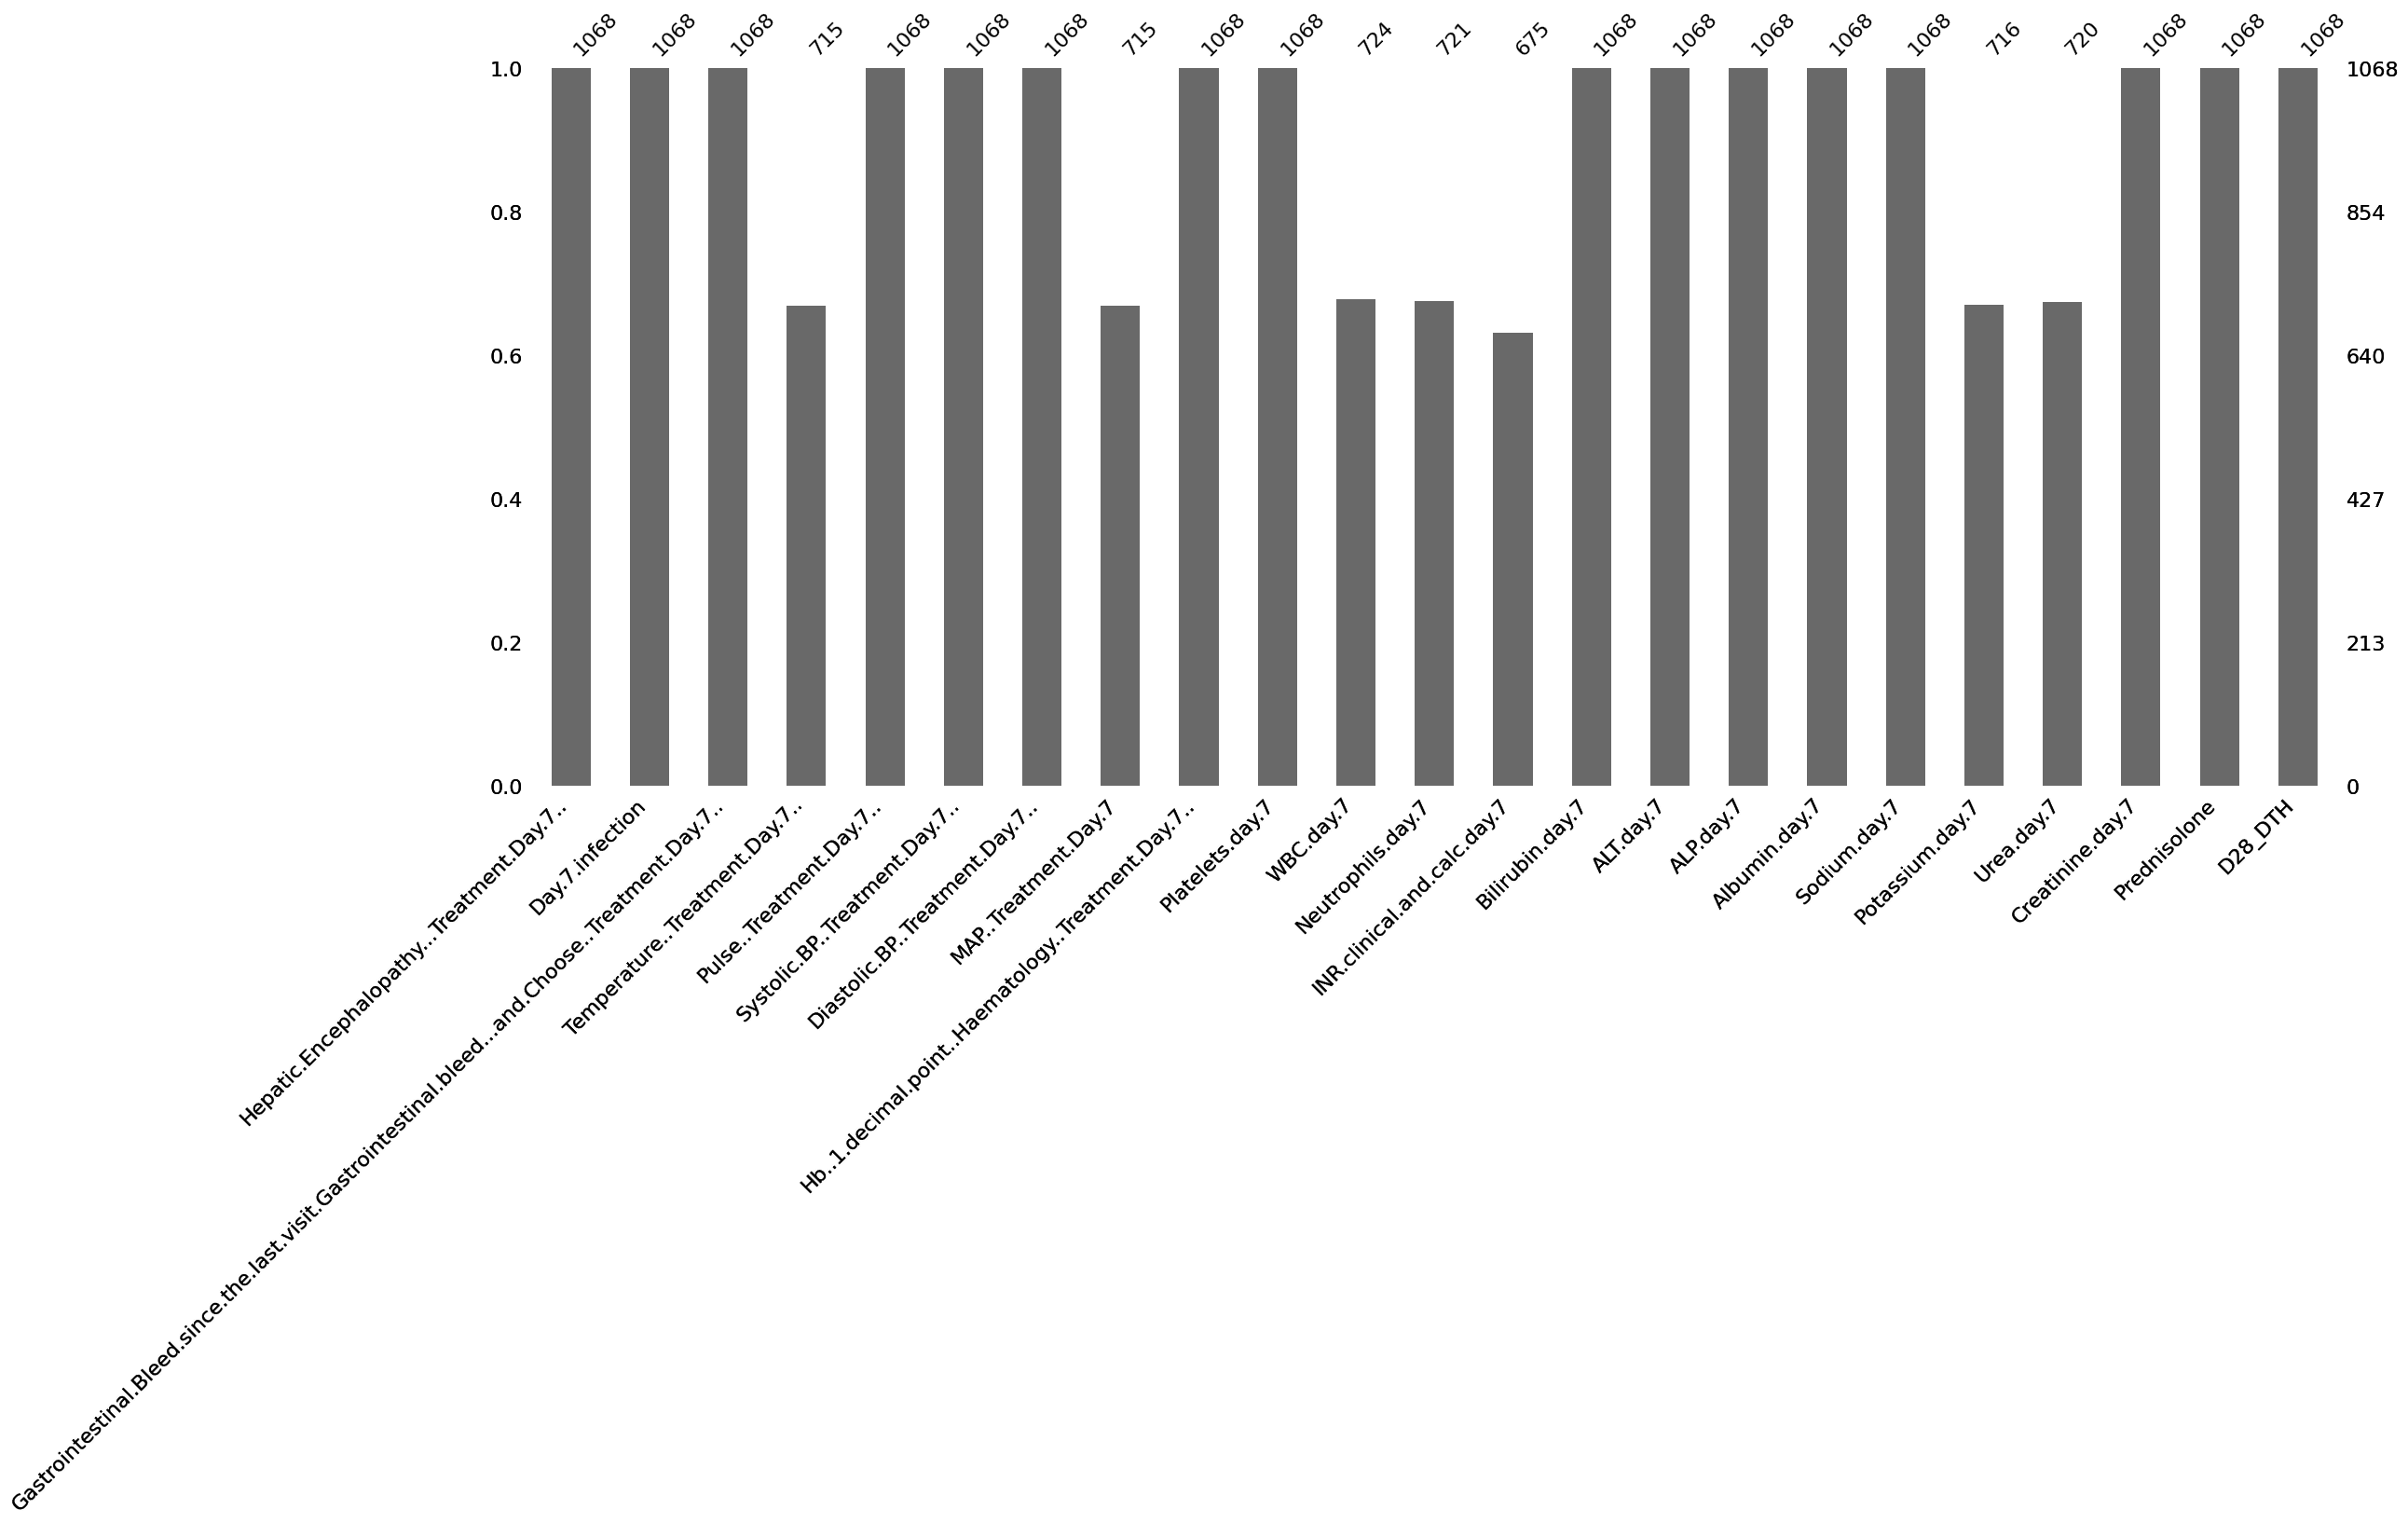

In [4]:
## Missing data situation

%matplotlib inline
msno.bar(stopah)
fig = msno.bar(stopah)
fig_copy = fig.get_figure()

In [5]:
stopah = stopah.dropna()

In [6]:
df = stopah.loc[stopah['Prednisolone']==0]

In [7]:
df

Hepatic.Encephalopathy...Treatment.Day.7..  Day.7.infection  \
0                                              1                0   
2                                              0                0   
3                                              0                0   
6                                              0                0   
7                                              0                0   
...                                          ...              ...   
1055                                 -2147483648                0   
1058                                           1                0   
1063                                           1                0   
1064                                           0                0   
1067                                           1                1   

      Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..  \
0                                                     0                                                    
2                                                     0                                                    
3                                                     0                                                    
6                                                     0                                                    
7                                                     1                                                    
...                                                 ...                                                    
1055                                                  0                                                    
1058                                                  0                                                    
1063                                                  0                                                    
1064                                                  0                                                    
1067                                                  0                                                    

      Temperature..Treatment.Day.7..  Pulse..Treatment.Day.7..  \
0                               36.8                        86   
2                               37.5                        91   
3                               36.5                        87   
6                               37.3                        92   
7                               36.6                       105   
...                              ...                       ...   
1055                            36.5                        90   
1058                            37.1                        68   
1063                            37.1                        75   
1064                            36.4                        84   
1067                            36.4                       100   

      Systolic.BP..Treatment.Day.7..  Diastolic.BP..Treatment.Day.7..  \
0                                135                               74   
2                                102                               62   
3                                133                               68   
6                                112                               62   
7                                 97                               60   
...                              ...                              ...   
1055                              98                               67   
1058                              88                               34   
1063                             117                               77   
1064                             126                               81   
1067                             103                               70   

      MAP..Treatment.Day.7  \
0                94.333333   
2                75.333333   
3                89.666667   
6                78.666667   
7                72.333333   
...                    ...   


In [8]:
df = df.drop(['Prednisolone'],axis=1)

In [9]:
# Split data, with total count serving as regression target
train, test = train_test_split(
    df.values, test_size=int(0.25 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.25 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

In [10]:
#Balance weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=Y_train #provide your own target name
)


rf = RandomForestClassifier(n_estimators=15,max_depth=8,random_state=24,criterion='gini',min_samples_split=10)

In [11]:
model = rf.fit(train, Y_train)

In [12]:
pred_prob = rf.predict_proba(test)

auc_score = roc_auc_score(Y_test, pred_prob[:,1])

print('Training accuracy: ', np.mean(rf.predict(train) ==Y_train)*100) 
print ('Test accuracy:', np.mean(rf.predict(test) ==Y_test)*100)
print('AUC Score:',(auc_score)*100)

Training accuracy:  93.02325581395348
Test accuracy: 88.23529411764706
AUC Score: 69.33760683760684


In [13]:
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

fpr, tpr, thresh = roc_curve(Y_test, pred_prob[:,1], pos_label=1)

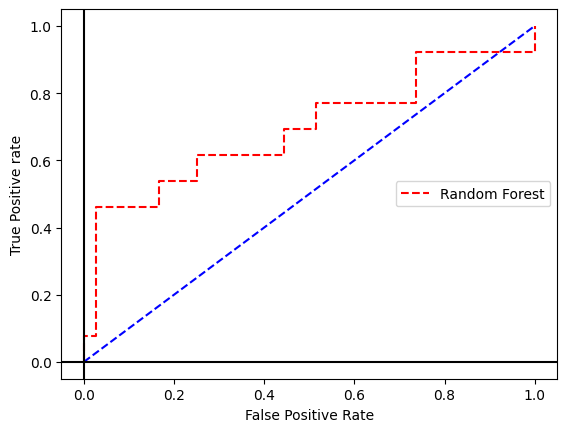

In [14]:
plt.axes(facecolor='white')
# plot roc curves

plt.plot(fpr, tpr, linestyle='--',color='red',label='Random Forest') #label='Random Forest'
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

#plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.grid(False)

plt.axhline(0, color='black')
plt.axvline(0, color='black')

#ax = fig.add_axes([1,1,0,0])

#ax.set_facecolor("white")

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();



In [15]:
from sklearn.inspection import permutation_importance

In [16]:
rf.feature_importances_

array([0.06274039, 0.        , 0.01429058, 0.07106763, 0.03518234,
       0.02278486, 0.03917513, 0.04812617, 0.08665219, 0.08655011,
       0.03044699, 0.01475975, 0.10140332, 0.20635447, 0.03907296,
       0.03213254, 0.02137302, 0.02178629, 0.06610127])

In [17]:
features = df.columns

In [18]:
features

Index(['Hepatic.Encephalopathy...Treatment.Day.7..', 'Day.7.infection',
       'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
       'Temperature..Treatment.Day.7..', 'Pulse..Treatment.Day.7..',
       'Systolic.BP..Treatment.Day.7..', 'Diastolic.BP..Treatment.Day.7..',
       'MAP..Treatment.Day.7',
       'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
       'Platelets.day.7', 'WBC.day.7', 'Neutrophils.day.7',
       'INR.clinical.and.calc.day.7', 'Bilirubin.day.7', 'ALT.day.7',
       'ALP.day.7', 'Albumin.day.7', 'Sodium.day.7', 'Potassium.day.7',
       'Urea.day.7', 'Creatinine.day.7', 'D28_DTH'],
      dtype='object')

Text(0, 0.5, 'variable')

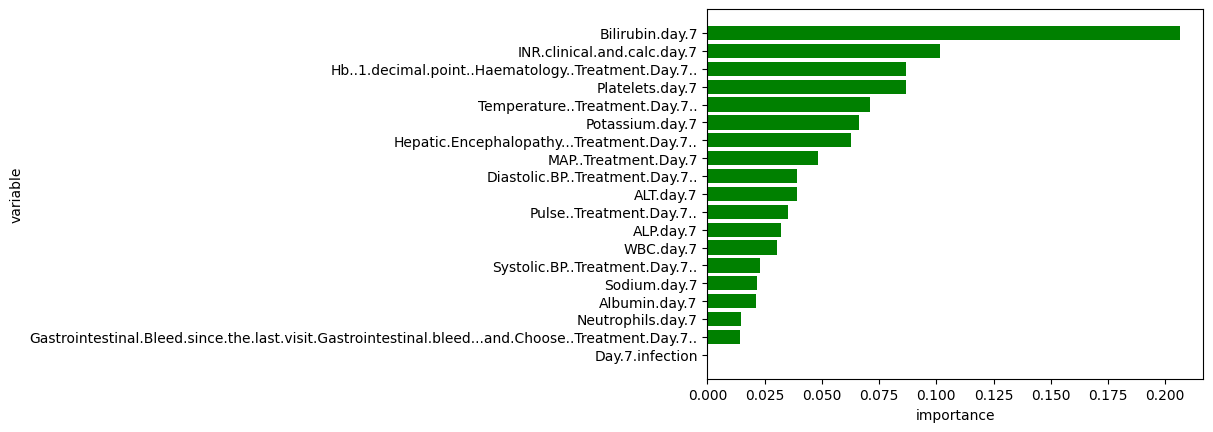

In [19]:
importances = rf.feature_importances_
indices = np.argsort(importances)

values = list(rf.feature_importances_[indices])

#values = [ '%.2f' % elem for elem in values ]

names = [features[i] for i in indices]

importance = pd.DataFrame({'variable' : names, 'importance': values})

importance = importance.sort_values('importance')

plt.axes(facecolor='white')
plt.barh(importance.variable,importance.importance,color='green')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

In [20]:
importance

variable  importance
0                                     Day.7.infection    0.000000
1   Gastrointestinal.Bleed.since.the.last.visit.Ga...    0.014291
2                                   Neutrophils.day.7    0.014760
3                                       Albumin.day.7    0.021373
4                                        Sodium.day.7    0.021786
5                      Systolic.BP..Treatment.Day.7..    0.022785
6                                           WBC.day.7    0.030447
7                                           ALP.day.7    0.032133
8                            Pulse..Treatment.Day.7..    0.035182
9                                           ALT.day.7    0.039073
10                    Diastolic.BP..Treatment.Day.7..    0.039175
11                               MAP..Treatment.Day.7    0.048126
12         Hepatic.Encephalopathy...Treatment.Day.7..    0.062740
13                                    Potassium.day.7    0.066101
14                     Temperature..Treatment.Day.7..    0.071068
15                                    Platelets.day.7    0.086550
16  Hb..1.decimal.point..Haematology..Treatment.Da...    0.086652
17                        INR.clinical.and.calc.day.7    0.101403
18                                    Bilirubin.day.7    0.206354

In [21]:
feature_names = stopah.columns.tolist()[:-1]

In [22]:
feature_names

['Hepatic.Encephalopathy...Treatment.Day.7..',
 'Day.7.infection',
 'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
 'Temperature..Treatment.Day.7..',
 'Pulse..Treatment.Day.7..',
 'Systolic.BP..Treatment.Day.7..',
 'Diastolic.BP..Treatment.Day.7..',
 'MAP..Treatment.Day.7',
 'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
 'Platelets.day.7',
 'WBC.day.7',
 'Neutrophils.day.7',
 'INR.clinical.and.calc.day.7',
 'Bilirubin.day.7',
 'ALT.day.7',
 'ALP.day.7',
 'Albumin.day.7',
 'Sodium.day.7',
 'Potassium.day.7',
 'Urea.day.7',
 'Creatinine.day.7',
 'Prednisolone']

In [ ]:
plt.axes(facecolor='white')
plt.barh(perm_imp.variable,perm_imp.importance,color='green')
plt.grid(False)
plt.xlabel('importance')
plt.ylabel('variable')

In [24]:
model = rf.fit(train, Y_train)

In [ ]:
# Setup and calculate
imputer = sage.MarginalImputer(model, train[:512])
estimator = sage.KernelEstimator(imputer, 'cross entropy')
sage_train = estimator(train, Y_train, thresh=0.025)
sage_val = estimator(val, Y_val, thresh=0.025)
sage_test = estimator(test, Y_test, thresh=0.025)

100%|██████████| 1/1 [12:28<00:00, 748.32s/it]     
 82%|████████▏ | 0.818/1 [10:35<02:21, 776.50s/it]  

In [ ]:
sage.comparison_plot((sage_train, sage_val, sage_test),
                     ('Train', 'Val', 'Test'),
                     feature_names,
                     colors=('tab:orange', 'tab:purple', 'tab:green'),
                     title='Train vs. Val vs. Test')
